# Figures

Random figures needed for other things

## Special Function Plots

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# L = np.pi
# h = 2

# x = np.linspace(-L, L, 1000)
# # f = lambda x: h * np.where((-L <= x) & (x <= -L/2), 0, np.where((-L/2 < x) & (x < L/2), 1, np.where((L/2 <= x) & (x <= L), 0, np.nan)))
# f = lambda x: h * np.where(x >= 0, 0, h)

# def partial_sum(x, n):
#     y = h / 2 * np.ones(x.shape)
#     # y += sum([2 * h / np.pi * (-1)**n / (2*n + 1) * np.cos((2*n + 1) * np.pi * x / L) for n in range(2*n + 1)])
#     y += sum([-2 * h / np.pi * np.sin(n * np.pi * x / L) / n for n in range(1, n+1, 2)])
#     return y

# plt.plot(x, f(x), alpha=1, linewidth=2, zorder=0, label='$f(x)$')
# plt.plot(x, partial_sum(x, 1), alpha=0.8, linewidth=1, zorder=1, label='$S_1$')
# plt.plot(x, partial_sum(x, 5), alpha=0.8, linewidth=1, zorder=2, label='$S_{5}$')
# plt.plot(x, partial_sum(x, 10), alpha=0.8, linewidth=1, zorder=3, label='$S_{10}$')
# plt.plot(x, partial_sum(x, 100), alpha=0.8, linewidth=1, zorder=4, label='$S_{100}$')
# plt.xlabel('$x$')
# plt.ylabel('$y$')
# plt.xlim(-L, L)
# plt.ylim(-0.3, h * 1.2)
# plt.legend(loc='upper right')
# plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import scipy.special as sp
# from scipy.integrate import quad
# import math

# f = lambda x: np.where(x < 0, -1, np.where(x > 0, 1, np.nan))
# log_a = lambda n: mpmath.log(2*n + 1) + mpmath.log(mpmath.factorial(n-2)) - mpmath.log(2) * ((n + 1) // 2) - mpmath.log(mpmath.factorial((n-1)//2)) - mpmath.log(mpmath.factorial((n+1)//2))

# def legendre_coefficient(n):
#     integrand_left = lambda x: f(x) * sp.eval_legendre(n, x)
#     integral_left = quad(integrand_left, -1, 0, limit=100)[0]
#     integrand_right = lambda x: f(x) * sp.eval_legendre(n, x)
#     integral_right = quad(integrand_right, 0, 1, limit=100)[0]
#     return (2 * n + 1) / 2 * (integral_left + integral_right)

# def legendre_partial_sum(x, N):
#     y = np.zeros(x.shape)
#     for n in range(N + 1):
#         if n % 2 == 1:
#             an = legendre_coefficient(n)
#             y += an * sp.eval_legendre(n, x)
#     return y

# x = np.linspace(-1, 1, 1000)

# plt.plot(x, f(x), alpha=1, linewidth=2, zorder=0, label='$f(x)$')
# plt.plot(x, legendre_partial_sum(x, 3), alpha=0.8, linewidth=1, zorder=2, label='$S_{3}$')
# plt.plot(x, legendre_partial_sum(x, 5), alpha=0.8, linewidth=1, zorder=3, label='$S_{5}$')
# plt.plot(x, legendre_partial_sum(x, 7), alpha=0.8, linewidth=1, zorder=4, label='$S_{7}$')
# plt.plot(x, legendre_partial_sum(x, 99), alpha=0.8, linewidth=1, zorder=5, label='$S_{99}$')

# plt.xlabel('$x$')
# plt.ylabel('$y$')
# plt.xlim(-1, 1)
# plt.ylim(-2, 2)
# plt.legend(loc='lower right')
# plt.show()

## Field Line Plots

In [132]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import *
from scipy.integrate import ode

class FieldLinePlotter:
    def __init__(self, distribution):
        self.distribution = distribution

    def _field_dir(self, t, state):
        x, y = state
        field_x, field_y = self.distribution.field(x, y)
        field_norm = np.sqrt(Fx**2 + Fy**2)
        if field_norm < 1e-14:
            return [0, 0] # avoid division by zero
        return [field_x / field_norm, field_y / field_norm]

    def _compute_field_lines(self):
        x_lines, y_lines = [], []
        seeds = self.distribution.seed_points(self.n_field_lines, self.step_size) 
        for (x_init, y_init) in seeds:
            for direction in [+1, -1]:
                solver = ode(self._field_dir)
                solver.set_integrator('vode')
                solver.set_f_params(self.distribution)
                solver.set_initial_value([x_init, y_init], 0)      
                x_line = [x_init]
                y_line = [y_init]
                dt = direction * self.dt_factor * self.step_size
                while solver.successful():
                    x_prev, y_prev = solver.y.copy()
                    solver.integrate(solver.t + dt)
                    x_new, y_new = solver.y
                    x_line.append(x_new)
                    y_line.append(y_new)
                    if not (self.x_range[0] < x_new < self.x_range[1] and self.y_range[0] < y_new < self.y_range[1]):
                        break # break if outside drawing area
                    if np.hypot(x_new - x_prev, y_new - y_prev) < 1e-6:
                        break # break if steps aren't advancing
                x_lines.append(x_line)
                y_lines.append(y_line)
        self.x_lines = x_lines
        self.y_lines = y_lines

    def _compute_potentials(self, grid_size=100):
        x_vals = np.linspace(self.x_range[0], self.x_range[1], grid_size)
        y_vals = np.linspace(self.y_range[0], self.y_range[1], grid_size)
        x_grid, y_grid = np.meshgrid(x_vals, y_vals)
        potentials = np.vectorize(lambda x, y: self.distribution.potential(x, y))(x_grid, y_grid)
        self.x_grid = x_grid
        self.y_grid = y_grid
        self.potentials = potentials

    def compute(self, n_field_lines=32, n_potential_levels=10, x_range=(-3, 3), y_range=(-3, 3), step_size=0.01, dt_factor=0.8):
        self.n_field_lines = n_field_lines
        self.n_potential_levels = n_potential_levels
        self.x_range = x_range
        self.y_range = y_range
        self.step_size = step_size
        self.dt_factor = dt_factor
        self._compute_field_lines()
        self._compute_potentials()

    def plot(self, plot_distribution=True, plot_field_lines=True, plot_equipotentials=False, line_width=0.5, line_alpha=0.8, 
             xlim=(-3, 3), ylim=(-3, 3), figsize=(6, 6)):
        plt.figure(figsize=figsize)
        ax = plt.gca()
        if plot_equipotentials and hasattr(self.distribution, 'potential'):
            ax.contour(self.x_grid, self.y_grid, self.potentials, levels=self.n_potential_levels, colors='green', 
                       linewidths=line_width, alpha=line_alpha)
        if plot_field_lines:
            for x_line, y_line in zip(self.x_lines, self.y_lines):
                ax.plot(x_line, y_line, color='black', linewidth=line_width, alpha=line_alpha)
        if plot_distribution:
            self.distribution.plot_distribution(ax, xlim=self.x_range, ylim=self.y_range)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.axis('off')
        ax.set_aspect('equal', adjustable='box')
        plt.show()
        return ax

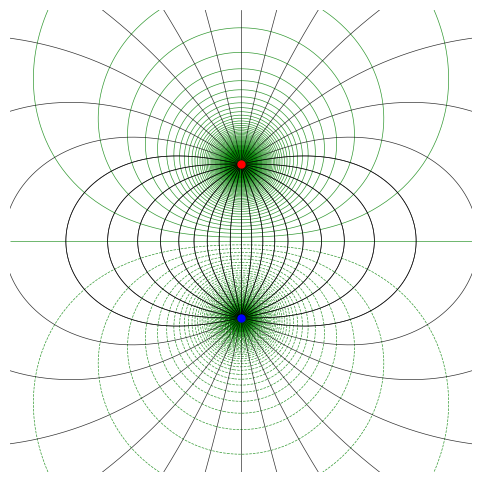

In [143]:
class PointCharge:
    def __init__(self, q, position):
        self.q = q
        self.x = position[0]
        self.y = position[1]

    def field(self, x, y):
        dx = x - self.x
        dy = y - self.y
        r2 = dx**2 + dy**2
        if r2 < 1e-12:
            return (0, 0) # avoid singularity at charge position
        r3 = r2 ** 1.5
        return (self.q * dx / r3, self.q * dy / r3)

    def seed_points(self, n_field_lines, step_size):
        angles = np.linspace(0, 2 * np.pi * (n_field_lines - 1) / n_field_lines, n_field_lines)
        seeds = []
        for angle in angles:
            x0 = self.x + np.cos(angle) * step_size
            y0 = self.y + np.sin(angle) * step_size
            seeds.append((x0, y0))
        return seeds

    def plot_distribution(self, ax, xlim, ylim):
        if self.q > 0:
            ax.plot(self.x, self.y, 'o', color='red', ms=5)
        elif self.q < 0:
            ax.plot(self.x, self.y, 'o', color='blue', ms=5)

    def potential(self, x, y):
        dx = x - self.x
        dy = y - self.y
        r = np.sqrt(dx**2 + dy**2)
        if r < 1e-6:
            r = 1e-6
        return self.q / r

class ChargeDistribution:
    def __init__(self, sources):
        self.sources = sources

    def field(self, x, y):
        Ex, Ey = 0, 0
        for src in self.sources:
            Fx, Fy = src.field_vector(x, y)
            Ex += Fx
            Ey += Fy
        return Ex, Ey

    def seed_points(self, n_field_lines, step_size):
        seeds = []
        for src in self.sources:
            seeds.extend(src.seed_points(n_field_lines, step_size))
        return seeds

    def plot_distribution(self, ax, xlim, ylim):
        for src in self.sources:
            src.plot_distribution(ax, xlim, ylim)

    def potential(self, x, y):
        potential = 0
        for src in self.sources:
            potential += src.potential(x, y)
        return potential

# charges = [PointCharge(1, (0, 0))]
charges = [PointCharge(-1, (0, -1)), PointCharge(1, (0, 1))]
# charges = [PointCharge(1, [1, 1]), PointCharge(-1, [1, -1]), PointCharge(1, [-1, -1]), PointCharge(-1, [-1, 1])]
distribution = ChargeDistribution(charges)
plotter = FieldLinePlotter(distribution)
plotter.plot(n_field_lines=32, xlim=(-3, 3), ylim=(-3, 3), plot_equipotentials=True, n_potential_levels=800);

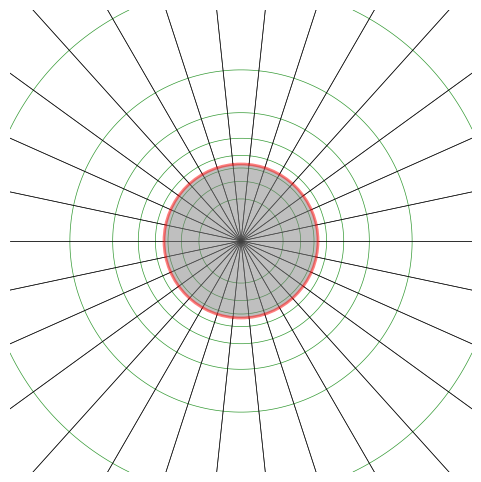

In [141]:
class InfiniteSheetDistribution:
    def __init__(self, sigma, center=(0, 0), normal_angle=90, span_length=3):
        self.sigma = sigma
        self.center = np.array(center, dtype=float)
        self.normal_angle = normal_angle * np.pi / 180
        self.normal = np.array([np.cos(self.normal_angle), np.sin(self.normal_angle)])
        self.tangent = np.array([-np.sin(self.normal_angle), np.cos(self.normal_angle)])
        self.span_length = span_length

    def field(self, x, y):
        r_vec = np.array([x, y], dtype=float) - self.center
        d = np.dot(r_vec, self.normal)
        if d >= 0:
            return (self.sigma / 2) * self.normal
        else:
            return -(self.sigma / 2) * self.normal

    def potential(self, x, y):
        r_vec = np.array([x, y], dtype=float) - self.center
        d = np.dot(r_vec, self.normal)
        return -(self.sigma / 2) * d

    def seed_points(self, n_field_lines, step_size):
        s_values = np.linspace(-self.span_length, self.span_length, n_field_lines)
        seeds_top = []
        seeds_bottom = []
        for s in s_values:
            base_point = self.center + s * self.tangent
            seeds_top.append(tuple(base_point + step_size * self.normal))
            seeds_bottom.append(tuple(base_point - step_size * self.normal))
        return seeds_top + seeds_bottom

    def plot_distribution(self, ax, xlim, ylim):
        color = 'red' if self.sigma > 0 else 'blue'
        L = max(xlim[1] - xlim[0], ylim[1] - ylim[0]) * 2
        p1 = self.center - (L / 2) * self.tangent
        p2 = self.center + (L / 2) * self.tangent
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], '-', color=color, linewidth=2)

class HollowSphereDistribution:
    def __init__(self, sigma, radius, center=(0, 0)):
        self.sigma = sigma
        self.radius = radius
        self.center = center

    def field(self, x, y):
        dx = x - self.center[0]
        dy = y - self.center[1]
        r = np.sqrt(dx**2 + dy**2)
        if r < self.radius:
            return (0, 0)
        else:
            factor = self.sigma * (self.radius**2) / (r**3)
            return (factor * dx, factor * dy)

    def potential(self, x, y):
        dx = x - self.center[0]
        dy = y - self.center[1]
        r = np.sqrt(dx**2 + dy**2)
        if r < self.radius:
            return self.sigma * (self.radius**2) / self.radius
        else:
            return self.sigma * (self.radius**2) / r      

    def seed_points(self, n_field_lines, step_size):
        angles = np.linspace(0, 2 * np.pi, n_field_lines, endpoint=False)
        seeds_outside = [((self.radius + step_size) * np.cos(angle) + self.center[0], 
                          (self.radius + step_size) * np.sin(angle) + self.center[1]) for angle in angles]
        seeds_inside  = [((self.radius - step_size) * np.cos(angle) + self.center[0], 
                          (self.radius - step_size) * np.sin(angle) + self.center[1]) for angle in angles]
        return seeds_outside + seeds_inside

    def plot_distribution(self, ax, xlim, ylim):
        color = 'red' if self.sigma > 0 else 'blue'
        circle = plt.Circle(self.center, self.radius, edgecolor=color, facecolor='none', linewidth=2, zorder=10)
        ax.add_patch(circle)

class SolidSphereDistribution:
    def __init__(self, sigma, radius, center=(0, 0)):
        self.sigma = sigma
        self.radius = radius
        self.center = center

    def field(self, x, y):
        dx = x - self.center[0]
        dy = y - self.center[1]
        r = np.sqrt(dx**2 + dy**2)
        if r < self.radius:
            factor = self.sigma * r / (self.radius ** 3)
            return (factor * dx, factor * dy)
        else:
            factor = self.sigma * (self.radius ** 2) / (r ** 3)
            return (factor * dx, factor * dy)

    def potential(self, x, y):
        dx = x - self.center[0]
        dy = y - self.center[1]
        r = np.sqrt(dx**2 + dy**2)
        if r < self.radius:
            return self.sigma * (3*self.radius**2 - r**2) / (2 * self.radius)
        else:
            return self.sigma * (self.radius**2) / r

    def seed_points(self, n_field_lines, step_size):
        angles = np.linspace(0, 2 * np.pi, n_field_lines, endpoint=False)
        seeds_outside = [((self.radius + step_size) * np.cos(angle) + self.center[0], 
                          (self.radius + step_size) * np.sin(angle) + self.center[1]) for angle in angles]
        seeds_inside  = [((self.radius - step_size) * np.cos(angle) + self.center[0], 
                          (self.radius - step_size) * np.sin(angle) + self.center[1]) for angle in angles]
        return seeds_outside + seeds_inside

    def plot_distribution(self, ax, xlim, ylim):
        color = 'red' if self.sigma > 0 else 'blue'
        circle = plt.Circle(self.center, self.radius, edgecolor=color, facecolor='gray', linewidth=2, zorder=10, alpha=0.5)
        ax.add_patch(circle)

# # Infinite sheet of charge
# sheet_distribution = InfiniteSheetDistribution(sigma=1, center=(0, 0), normal_angle=-90, span_length=6)
# plotter = FieldLinePlotter(sheet_distribution)
# plotter.plot(n_field_lines=32, xlim=(-3, 3), ylim=(-3, 3), plot_equipotentials=True)

# # Hollow sphere of charge
# hollow_sphere = HollowSphereDistribution(sigma=1, radius=1, center=(0, 0))
# plotter = FieldLinePlotter(hollow_sphere)
# plotter.plot(n_field_lines=30, xlim=(-3, 3), ylim=(-3, 3), plot_equipotentials=True)

# Solid sphere of charge
solid_sphere = SolidSphereDistribution(sigma=1, radius=1, center=(0, 0))
plotter = FieldLinePlotter(solid_sphere)
plotter.plot(n_field_lines=30, xlim=(-3, 3), ylim=(-3, 3), plot_equipotentials=True);

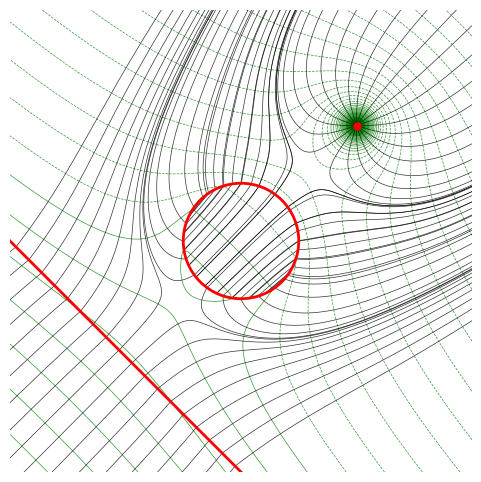

In [136]:


# charge = PointCharge(q=1, position=(2, 2))
# sphere = HollowSphereDistribution(sigma=1, radius=1, center=(0, 0))
# sheet = InfiniteSheetDistribution(sigma=1, center=(-2, -2), normal_angle=45)
# distribution = ChargeDistribution([charge, sphere, sheet])

# charge = PointCharge(q=0.01, position=(1, 1))
# vertical_sheet = InfiniteSheetDistribution(sigma=5, center=(0, 0), normal_angle=0)
# horizontal_sheet = InfiniteSheetDistribution(sigma=5, center=(0, 0), normal_angle=90)
# distribution = ChargeDistribution([vertical_sheet, horizontal_sheet])

plotter = FieldLinePlotter(distribution)
plotter.plot(n_field_lines=20, xlim=(-4, 4), ylim=(-4, 4), plot_equipotentials=True, n_potential_levels=150);

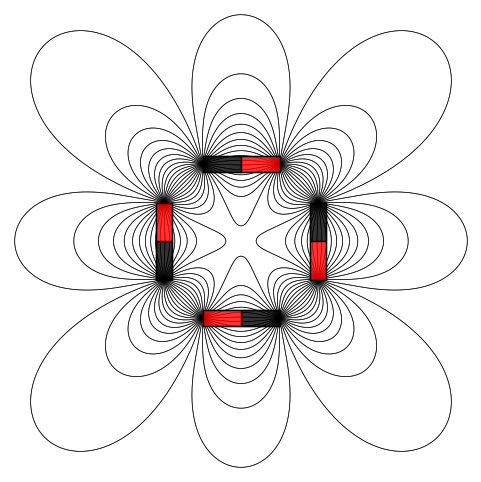

In [145]:
class MagneticDipole:
    def __init__(self, m, center, angle, length, width=0.4):
        self.m = m
        self.center = np.array(center, dtype=float)
        self.angle = angle * np.pi / 180
        self.length = length
        self.width = width
        self.u = np.array([np.cos(self.angle), np.sin(self.angle)])
        self.v = np.array([-np.sin(self.angle), np.cos(self.angle)])
        self.north_position = self.center + (self.length / 2) * self.u
        self.south_position = self.center - (self.length / 2) * self.u

class MagneticDipoleDistribution:
    def __init__(self, dipoles):
        self.dipoles = dipoles

    def field(self, x, y):
        # each dipole is modeled as two monopoles, one at the north pole (+m) and one at the south pole (-m).
        Bx, By = 0, 0
        point = np.array([x, y], dtype=float)
        for dipole in self.dipoles:
            # north pole
            r_north = point - dipole.north_position
            r2_north = np.dot(r_north, r_north)
            if r2_north > 1e-12:
                r3_north = r2_north ** 1.5
                Bx += dipole.m * r_north[0] / r3_north
                By += dipole.m * r_north[1] / r3_north
            # south pole
            r_south = point - dipole.south_position
            r2_south = np.dot(r_south, r_south)
            if r2_south > 1e-12:
                r3_south = r2_south ** 1.5
                Bx += -dipole.m * r_south[0] / r3_south
                By += -dipole.m * r_south[1] / r3_south
        return Bx, By

    def seed_points(self, n_field_lines, step_size):
        seeds = []
        angles = np.linspace(0, 2 * np.pi * (n_field_lines - 1) / n_field_lines, n_field_lines)
        for dipole in self.dipoles:
            for pole in [dipole.north_position, dipole.south_position]:
                for angle in angles:
                    x0 = pole[0] + np.cos(angle) * step_size
                    y0 = pole[1] + np.sin(angle) * step_size
                    seeds.append((x0, y0))
        return seeds

    def plot_distribution(self, ax, xlim, ylim):
        for dipole in self.dipoles:
            # u is the unit vector along the dipole axis and v is perpendicular
            half_length = dipole.length / 2
            half_width = dipole.width / 2
            center = dipole.center
            # northern half: from center to center + half_length * u
            north_corners = [center - half_width * dipole.v, center + half_width * dipole.v, 
                             center + half_width * dipole.v + half_length * dipole.u, center - half_width * dipole.v + half_length * dipole.u]
            north_poly = Polygon(north_corners, closed=True, facecolor='red', edgecolor='red', alpha=0.8, zorder=10)
            # southern half: from center to center - half_length * u
            south_corners = [center - half_width * dipole.v, center + half_width * dipole.v, 
                             center + half_width * dipole.v - half_length * dipole.u, center - half_width * dipole.v - half_length * dipole.u]
            south_poly = Polygon(south_corners, closed=True, facecolor='black', edgecolor='black', alpha=0.8, zorder=10)
            ax.add_patch(north_poly)
            ax.add_patch(south_poly)
            # draw an outline for the entire dipole
            full_corners = [center - half_width * dipole.v - half_length * dipole.u, center + half_width * dipole.v - half_length * dipole.u, 
                            center + half_width * dipole.v + half_length * dipole.u, center - half_width * dipole.v + half_length * dipole.u]
            outline = Polygon(full_corners, closed=True, fill=False, edgecolor='black', linewidth=1, zorder=11)
            ax.add_patch(outline)

distribution = MagneticDipoleDistribution([
    MagneticDipole(m=1, center=[0, 1], angle=0, length=1.0, width=0.2),
    MagneticDipole(m=1, center=[1, 0], angle=-90, length=1.0, width=0.2),
    MagneticDipole(m=1, center=[0, -1], angle=180, length=1.0, width=0.2),
    MagneticDipole(m=1, center=[-1, 0], angle=90, length=1.0, width=0.2)
])
plotter = FieldLinePlotter(distribution)
plotter.plot(n_field_lines=40, xlim=(-3, 3), ylim=(-3, 3));

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# from scipy.integrate import ode as ode
# from matplotlib import cm
# from tqdm.notebook import tqdm
# # from itertools import product

# class charge:
#     def __init__(self, q, pos):
#         self.q=q
#         self.pos=pos
 
# def E_point_charge(q, a, x, y):
#     return q*(x-a[0])/((x-a[0])**2+(y-a[1])**2)**(1.5), \
#         q*(y-a[1])/((x-a[0])**2+(y-a[1])**2)**(1.5)
 
# def E_total(x, y, charges):
#     Ex, Ey=0, 0
#     for C in charges:
#         E=E_point_charge(C.q, C.pos, x, y)
#         Ex=Ex+E[0]
#         Ey=Ey+E[1]
#     return [ Ex, Ey ]

# def E_dir(t, y, charges):
#     Ex, Ey=E_total(y[0], y[1], charges)
#     n=np.sqrt(Ex**2+Ey*Ey)
#     return [Ex/n, Ey/n]

# # # charges and positions
# n_lines = 32 # 2 * 2048
# # charges = [charge(1, [0, 0])]
# # charges = [charge(1, [0, -d]), charge(1, [0, d])]
# charges = [charge(-1, [0, -1]), charge(1, [0, 1])]
# # charges = [charge(-1, [0, -d]), charge(4, [0, d])]
# # charges = [charge(1, [1, 1]), charge(-1, [1, -1]), charge(1, [-1, -1]), charge(-1, [-1, 1])]
# # charges = [charge(1, [1, 1]), charge(1, [1, -1]), charge(1, [-1, -1]), charge(1, [-1, 1]),
# #            charge(-1, [0, d]), charge(-1, [-1, 0]), charge(-1, [0, -1]), charge(-1, [1, 0])]
# # charges = []
# # for x in np.linspace(-1.5, 1.5, 50):
# #     for y in np.linspace(-1.5, 1.5, 50):
# #         if x**2 + y**2 <= 1.5**2:
# #             charges.append(charge(1, [x, y]))

# # calculate field lines
# x0, x1=-3, 3
# y0, y1=-3, 3
# R=0.01
# # loop over all charges
# xs,ys = [],[]
# for C in tqdm(charges, leave=False):
#     # plot field lines starting in current charge
#     dt=0.8*R
#     if C.q<0:
#         dt=-dt
#     # loop over field lines starting in different directions 
#     # around current charge
#     for alpha in np.linspace(0, 2*np.pi*(n_lines-1)/n_lines, n_lines):
#         r=ode(E_dir)
#         r.set_integrator('vode')
#         r.set_f_params(charges)
#         x=[ C.pos[0] + np.cos(alpha)*R ]
#         y=[ C.pos[1] + np.sin(alpha)*R ]
#         r.set_initial_value([x[0], y[0]], 0)
#         while r.successful():
#             r.integrate(r.t+dt)
#             x.append(r.y[0])
#             y.append(r.y[1])
#             hit_charge=False
#             # check if field line left drwaing area or ends in some charge
#             for C2 in charges:
#                 if np.sqrt((r.y[0]-C2.pos[0])**2+(r.y[1]-C2.pos[1])**2)<R:
#                     hit_charge=True
#             if hit_charge or (not (x0<r.y[0] and r.y[0]<x1)) or \
#                     (not (y0<r.y[1] and r.y[1]<y1)):
#                 break
#         xs.append(x)
#         ys.append(y)

# plt.figure(figsize=(5.5, 4.5),facecolor="w")

# # plot field line
# for x, y in zip(xs,ys):
#     plt.plot(x, y, color="black", linewidth=0.5, alpha=0.8)

# # plot point charges
# for C in charges:
#     if C.q>0:
#         # plt.plot(C.pos[0], C.pos[1], 'wo', ms=70, markeredgecolor='k')
#         plt.plot(C.pos[0], C.pos[1], 'ro', ms=5) #*np.sqrt(C.q))
#     if C.q<0:
#         plt.plot(C.pos[0], C.pos[1], 'ko', ms=5) #*np.sqrt(-C.q))

# plt.xlim(x0, x1)
# plt.ylim(y0, y1)
# plt.axis('off')
# plt.axis('equal')
# plt.show()

# calculate and plot the electric potential

# def V_point_charge(q, a, x, y):
#     return q/((x-a[0])**2+(y-a[1])**2)**(0.5)

# def V_total(x, y, charges):
#     V=0
#     for C in charges:
#         Vp=V_point_charge(C.q, C.pos, x, y)
#         V = V+Vp
#     return V

# vvs = []
# xxs = []
# yys = []
# numcalcv = 300
# for xx,yy in product(np.linspace(x0,x1,numcalcv),np.linspace(y0,y1,numcalcv)):
#     xxs.append(xx)
#     yys.append(yy)
#     vvs.append(V_total(xx,yy,charges))
# xxs = np.array(xxs)
# yys = np.array(yys)
# vvs = np.array(vvs)

# clim0,clim1 = -2,2
# vvs[np.where(vvs<clim0)] = clim0*0.999999 # to avoid error
# vvs[np.where(vvs>clim1)] = clim1*0.999999 # to avoid error
# plt.tricontour(xxs,yys,vvs,10,colors="0.3")
# plt.tricontourf(xxs,yys,vvs,100,cmap=cm.jet)
# cbar = plt.colorbar()
# cbar.set_clim(clim0,clim1)
# cbar.set_ticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2])
# cbar.set_label("Electric Potential")
# plt.xlabel('$x$')
# plt.ylabel('$y$')
# plt.xlim(x0, x1)
# plt.ylim(y0, y1)
# plt.axes().set_aspect('equal','datalim')
# plt.savefig('electric_force_lines_1.png',dpi=250,bbox_inches="tight",pad_inches=0.02)
# plt.show()

## Other

In [ ]:
# ! llm 'Write a simple python hello world function'

In [1]:
# %load_ext jupyter_tikz

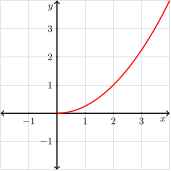

In [48]:
# %%tikz

# \begin{tikzpicture}
#     \draw[gray,very thin] (-2,-2) grid (4,4);
#     \draw[very thick,<->] (-2,0) -- (4,0) node[anchor=north east] {$x$};
#     \draw[very thick,<->] (0,-2) -- (0,4) node[anchor=north east] {$y$};
#     \foreach \x in {-1,1,2,3}
#        \draw (\x cm,1pt) -- (\x cm,-1pt) node[anchor=north] {$\x$};
#     \foreach \y in {-1,1,2,3}
#         \draw (1pt,\y cm) -- (-1pt,\y cm) node[anchor=east] {$\y$};
#     \draw[very thick,red] (0,0) parabola (4,4);
#     % \fill[white!40!blue] (0,0) parabola (4,4);
# \end{tikzpicture}

In [75]:
# %%tikz -as=full-document

# \documentclass{article}
# \usepackage[siunitx]{circuitikz}

# \begin{document}

# \begin{circuitikz} 
#     \draw 
#         (0,0) to[battery, l=V, i=I] (0,4)
#         to[R, l=R] (4,4)
#         to[L, l=L] (4,0) -- (3.5,0)
#         to[C, l=C] (0.5,0) -- (0,0)
#         % to[lamp, *-*] (0.5,0) -- (0,0)
#         % (0.5,0) -- (0.5,-2)
#         % to[voltmeter] (3.5,-2) -- (3.5,0)
#     ;
# \end{circuitikz}

# \end{document}